In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

import numpy as np
from pixell import enmap, enplot, reproject
import glob
import matplotlib.pyplot as plt
import emcee, corner
from astropy.io import fits
import sys
from astropy import units as u, constants as const
sys.path.insert(0, '../src')
import sys
import warnings
import os
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import yaml
import itertools
from pixell import enmap

import bandpass as bp
import covariance as cov
import model
import utils as ut

import SZpack as SZ

In [2]:
def sim_check(cf):
    """
    Check if the data is simulated or real.

    Parameters
    ----------
    cf : dict
        Configuration dictionary.
    
    Returns
    -------
    data_str_flag : str
        String flag for the data type.
    """
    if cf['system_type'] == 'sim':
        data_str_flag = "_srcfree_model"
    elif cf['system_type'] == 'real':
        data_str_flag = "_srcfree"
    elif cf['system_type'] == 'real_with_sources':
        data_str_flag = ""
    else:
        raise ValueError("Undefined system type.")
    return data_str_flag

def converge_plot(sampler, object_type, labels):
    plt.figure(figsize=(12, 8))
    for idx in range(len(labels)):
        chain = sampler.get_chain()[:, :, idx].T

        N = np.exp(np.linspace(np.log(10**2), np.log(chain.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = ut.autocorr_gw2010(chain[:, :n])
            new[i] = ut.autocorr_new(chain[:, :n])

        if (object_type in labels[idx]):
            plt.loglog(N, new, "o-", label=labels[idx])
            plt.xlabel("number of samples, $N$")
            plt.ylabel(r"$\tau$ estimates")
    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()
    
def plotter_sim(filename, target, p_range, plot_contours=False,
                plot_converge=False, burnin=1, 
                plot_samples=True, truths=None,
                thin=1, plot_maps=False, cf_name="cf_auto_all.yaml"):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    dire = f"/home/gill/research/ACT/bridge/"
    
    sampler = emcee.backends.HDFBackend(filename)
        
    cf = ut.get_config_file(cf_name)

    labels = ['c1ra', 'c1dec', 'c1beta', 'c1rc', 'c1e', 'c1theta', 'c1tau', 'c1T', 'c1Ad',
                'c2ra', 'c2dec', 'c2beta', 'c2rc', 'c2e', 'c2theta', 'c2tau', 'c2T', 'c2Ad',
                'filra', 'fildec', 'filL', 'filW', 'filtau', 'filTe', 'filAd', 'vavg']

    region = ut.get_region(cf['region_center_ra'], 
                           cf['region_center_dec'], 
                           cf['region_width'])
    
    data_ref = enmap.read_map(f"{os.environ['ACT_DATADIR']}/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits", 
                              box=region)

    
    data_wcs = data_ref.wcs
    
    ndim = len(labels)
    
    samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
    samples_unflat = sampler.get_chain(discard=burnin)
    
    print(f"Target: {target}")
    print("\nNumber of iterations: {:.0f}".format(samples.shape[0] / sampler.shape[0]))
    print("\nShape of sampler: {}".format(sampler.shape))
    print("Shape of samples: {}".format(samples.shape))
    print("\n******\nFit parameters (coordinates in units of pixels):\n--------")

    theta = []
        
    acc_frac = sampler.accepted / sampler.iteration
    print("*Average acceptance fraction is: {:.2f}%".format(np.mean(acc_frac)*100))

    
    for idx, label in enumerate(labels):
        mcmc_run = np.percentile(samples[:, idx], [16, 50, 84])
        q = np.diff(mcmc_run)
        
        if (label == 'c2ra' or label == 'filra' or label == 'vavg'): 
            print("\n{}: {:.4f}, -{:.4f}, {:.4f}".format(label, mcmc_run[1],  q[0], q[1]))        
        else:
            print("{}: {:.4f}, -{:.4f}, {:.4f}".format(label, mcmc_run[1],  q[0], q[1]))
        
        theta.append(mcmc_run[1])
    
    if plot_samples:
        fig, axes = plt.subplots(len(labels), figsize=(10, 35), sharex=True)

        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples_unflat[:, :, i], "k", alpha=0.4)
            ax.set_xlim(0, len(samples_unflat))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");
        plt.show()

    if plot_maps:

        
        c1 = model.Cluster(theta=theta, name="abell401")
        c2 = model.Cluster(theta=theta, name="abell399")
        fil = model.Filament(theta=theta)
        
        # 98
        freq = 98

        ref_data_98 = ut.imap_dim_check(enmap.read_map(f"{os.environ['ACT_DATADIR']}/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits", 
                                     box=region))

        data_shape = ref_data_98.shape
                
        xgrid, ygrid = np.meshgrid(np.arange(0, data_shape[1], 1), 
                                   np.arange(0, data_shape[0], 1))
              
        array = 'pa5'
        inst = 'act'
        scan = 'night'

        flux_factor_98 = ut.flux_factor(array, freq)

        ref_data_98 *= flux_factor_98 
        
        c1_model = c1.szmodel(frequency=freq, 
                              array=array, 
                              z=cf['c1_z'],
                              xgrid=xgrid, 
                              ygrid=ygrid,
                              muo=cf['c1_muo'])
        
        c2_model = c2.szmodel(frequency=freq,
                                array=array,
                                z=cf['c2_z'],
                                xgrid=xgrid,
                                ygrid=ygrid,
                                muo=cf['c2_muo'])

        fil_model = fil.szmodel(frequency=freq,
                                array=array,
                                xgrid=xgrid,
                                z=cf['fil_z'],
                                ygrid=ygrid, 
                                muo=cf['fil_muo'])
        
        total_model = c1_model + c2_model + fil_model        

        beam_98 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
                                 freq=freq, 
                                 array=array, 
                                 inst='act', 
                                 version=str(cf['beam_version']),
                                 data_wcs=data_wcs)

        model_tot_98 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_98))

        # 150 GHz
        freq = 150

        ref_data_150 = ut.imap_dim_check(enmap.read_map(f"{os.environ['ACT_DATADIR']}/act_cut_dr6v2_pa5_f150_4way_coadd_map_srcfree.fits", 
                                     box=region))

        data_shape = ref_data_150.shape
        xgrid, ygrid = np.meshgrid(np.arange(0, data_shape[1], 1), 
                                   np.arange(0, data_shape[0], 1))

        array = 'pa5'
        inst = 'act'
        scan = 'night'

        flux_factor_150 = ut.flux_factor(array, freq)

        ref_data_150 *= flux_factor_150   
        
        c1_model = c1.szmodel(frequency=freq, 
                              array=array, 
                              z=cf['c1_z'],
                              xgrid=xgrid,

                              ygrid=ygrid,
                              muo=cf['c1_muo'])
        
        c2_model = c2.szmodel(frequency=freq,
                                array=array,
                                z=cf['c2_z'],
                                xgrid=xgrid,
                                ygrid=ygrid,
                                muo=cf['c2_muo'])

        fil_model = fil.szmodel(frequency=freq,
                                array=array,
                                xgrid=xgrid,
                                z=cf['fil_z'],
                                ygrid=ygrid, muo=cf['fil_muo'])
        

        total_model = c1_model + c2_model + fil_model

        beam_150 = ut.get_2d_beam(data_shape=ref_data_150.shape, 
                                 freq=freq, 
                                 array=array, 
                                 inst='act', 
                                 version=str(cf['beam_version']),
                                 data_wcs=data_wcs)
        
        model_tot_150 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_150))

#         # 220 GHz
#         freq = 220

#         ref_data_220 = enmap.read_map(dire + f"night/act_cut_cmb_night_pa4_f220_8way_coadd_map_{data_str_flag}.fits", box=region)

#         data_shape = ref_data_220.shape
#         xgrid, ygrid = np.meshgrid(np.arange(0, data_shape[1], 1), 
#                                    np.arange(0, data_shape[0], 1))

#         array = 'pa4'

#         flux_factor_220 = ut.flux_factor(array, freq)

#         ref_data_220 *= flux_factor_220   

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_220 = ut.get_2d_beam(data_shape=ref_data_220.shape, 
#                                  freq=freq, 
#                                  array=array, 
#                                  inst='act', 
#                                  data_wcs=data_wcs)

#         model_tot_220 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_220))

#         # PLANCK
#         ## 30 GHz
#         freq = 30
#         ref_data_30 = enmap.read_map(dire + f"cutout_planck/planck_npipe_030_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_30 = ut.flux_factor(array, freq)
#         ref_data_30 *= flux_factor_30

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_30 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
        
#         model_tot_30 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_30))

#         ## 44 GHz
#         freq = 44
#         ref_data_44 = enmap.read_map(dire + f"cutout_planck/planck_npipe_044_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_44 = ut.flux_factor(array, freq)
#         ref_data_44 *= flux_factor_44

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_44 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
#         model_tot_44 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_44))

#         ## 70 GHz
#         freq = 70
#         ref_data_70 = enmap.read_map(dire + f"cutout_planck/planck_npipe_070_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_70 = ut.flux_factor(array, freq)
#         ref_data_70 *= flux_factor_70

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_70 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
        
#         model_tot_70 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_70))

#         ## 100 GHz
#         freq = 100
#         ref_data_100 = enmap.read_map(dire + f"cutout_planck/planck_npipe_100_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_100 = ut.flux_factor(array, freq)
#         ref_data_100 *= flux_factor_100

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_100 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
        
#         model_tot_100 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_100))

#         ## 143 GHz
#         freq = 143
#         ref_data_143 = enmap.read_map(dire + f"cutout_planck/planck_npipe_143_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_143 = ut.flux_factor(array, freq)
#         ref_data_143 *= flux_factor_143
        
#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_143 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
#         model_tot_143 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_143))

#         ## 217 GHz
#         freq = 217
#         ref_data_217 = enmap.read_map(dire + f"cutout_planck/planck_npipe_217_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_217 = ut.flux_factor(array, freq)
#         ref_data_217 *= flux_factor_217

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_217 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
#         model_tot_217 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_217))

#         ## 353 GHz
#         freq = 353
#         ref_data_353 = enmap.read_map(dire + f"cutout_planck/planck_npipe_353_coadd_map_{data_str_flag}.fits", box=region)
        
#         array = 'npipe'

#         flux_factor_353 = ut.flux_factor(array, freq)
#         ref_data_353 *= flux_factor_353


#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_353 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array,  
#                                    inst='planck', data_wcs=data_wcs)
#         model_tot_353 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_353))


#         ## 545 GHz
#         freq = 545
#         ref_data_545 = enmap.read_map(dire + f"cutout_planck/planck_npipe_545_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_545 = ut.flux_factor(array, freq)
#         ref_data_545 *= flux_factor_545

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_545 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
#         model_tot_545 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_545))


#         ## 857 GHz
#         freq = 857
#         ref_data_857 = enmap.read_map(dire + f"cutout_planck/planck_npipe_857_coadd_map_{data_str_flag}.fits", box=region)

#         array = 'npipe'

#         flux_factor_857 = ut.flux_factor(array, freq)
#         ref_data_857 *= flux_factor_857

#         c1_model = c1.szmodel(frequency=freq, 
#                               array=array, 
#                               z=cf['c1_z'], 
#                               r500_pix=c1_r500_pix,
#                               fit_dust=cf['fit_dust'],
#                               temp_model_type=cf['temp_model_type'],
#                               xgrid=xgrid, 
#                               ygrid=ygrid,
#                               interp_f_dict=interp_f_dict)
        
#         c2_model = c2.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c2_z'],
#                                 r500_pix=c2_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         c3_model = c3.szmodel(frequency=freq,
#                                 array=array,
#                                 z=cf['c3_z'],
#                                 r500_pix=c3_r500_pix,
#                                 fit_dust=cf['fit_dust'],
#                                 temp_model_type=cf['temp_model_type'],
#                                 xgrid=xgrid,
#                                 ygrid=ygrid,
#                                 interp_f_dict=interp_f_dict)
        
#         total_model = c1_model + c2_model + c3_model

#         beam_857 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
#                                    freq=freq, array=array, 
#                                    inst='planck', data_wcs=data_wcs)
#         model_tot_857 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_857))


        lab = f"I [mJy / steradian]"
        
        fig = plt.figure(figsize=(18, 85)) # create the canvas for plotting
        
        nrows = 12
        ncols = 3
        
        inst_dict = {'30':'Planck', '44':'Planck', '70':'Planck',
                     '100':'Planck', '143':'Planck', '217':'Planck',
                     '353':'Planck', "545":'Planck', "857":'Planck',
                     "98":'ACT', "150":'ACT', "220":'ACT'}
        
        array_dict = {'30':'npipe', '44':'npipe', '70':'npipe',
                      '100':'npipe', '143':'npipe', '217':'npipe',
                      '353':'npipe', "545":'npipe', "857":'npipe',
                      "98":'pa5', "150":'pa5', "220":'pa4'}
        
#         ref_data_dict = {'30':ref_data_30, '44':ref_data_44, '70':ref_data_70,
#                          '98':ref_data_98, '100':ref_data_100, '143':ref_data_143, 
#                          '150':ref_data_150, '217':ref_data_217, '220':ref_data_220,
#                          '353':ref_data_353, '545':ref_data_545, '857':ref_data_857}
        
#         model_tot_dict = {'30':model_tot_30, '44':model_tot_44, '70':model_tot_70,
#                          '98':model_tot_98, '100':model_tot_100, '143':model_tot_143, 
#                          '150':model_tot_150, '217':model_tot_217, '220':model_tot_220,
#                          '353':model_tot_353, '545':model_tot_545, '857':model_tot_857}
        
        ref_data_dict = {'98':ref_data_98, '150':ref_data_150}
        model_tot_dict = {'98':model_tot_98, '150':model_tot_150}

        freqs = ['30', '44', '70', '98', '100', '143', '150', '217', '220', '353', '545', '857']
        
        inst_dict = {'98':"ACT", "150":"ACT", "220":"ACT"}
        freqs = ['98', '150']
        
        for i, freq in enumerate(freqs):
                        
            ref_data = ref_data_dict[freq]
            model_tot = model_tot_dict[freq]
            
            ax1 = fig.add_subplot(nrows, ncols, i*3+1)
            im1 = ax1.imshow(ref_data / 10**3, origin='lower')
            ax1.invert_xaxis()
            cb1 = fig.colorbar(im1, cmap='viridis', ax=ax1, orientation="horizontal", pad=0.12)
            cb1.set_label(lab)
            ax1.set_ylabel('Declination [pixels]')
            ax1.set_xlabel('Right ascension [pixels]')
            ax1.set_title(f"Data, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=16)
        
            ax1 = fig.add_subplot(nrows, ncols, i*3+2)
            im1 = ax1.imshow(model_tot / 10**3, origin='lower')
            ax1.invert_xaxis()

            cb1 = fig.colorbar(im1, cmap='viridis', ax=ax1, orientation="horizontal", pad=0.12)
            cb1.set_label(lab)
            #ax1.set_ylabel('Declination [pixels]')
            ax1.set_xlabel('Right ascension [pixels]')
            ax1.set_title(f"Model, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=16)
            
            ax1 = fig.add_subplot(nrows, ncols, i*3+3)
            im1 = ax1.imshow((ref_data - model_tot) / 10**3, origin='lower')
            ax1.invert_xaxis()
            cb1 = fig.colorbar(im1, cmap='viridis', ax=ax1, orientation="horizontal", pad=0.12)
            cb1.set_label(lab)
            #ax1.set_ylabel('Declination [pixels]')
            ax1.set_xlabel('Right ascension [pixels]')
            ax1.set_title(f"Residual, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=16)
        
        #plt.savefig(f"figs/{target}.png", bbox_inches='tight')
        plt.show()
    
    if plot_converge:
        converge_plot(sampler, "c1", labels)
        converge_plot(sampler, "c2", labels)
        converge_plot(sampler, "fil", labels)
        converge_plot(sampler, "vavg", labels)

    if plot_contours: 
        
        if truths is not None:
            figure = corner.corner(samples, 
                                   labels=labels,
                                   truths=truths,
                                   range=p_range,                                  
                                   quantiles=[0.16, 0.5, 0.84],
                                   show_titles=True, 
                                   plot_datapoints=True,
                                   title_fmt=".3f")
        else:
            figure = corner.corner(samples, 
                       labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       range=p_range,
                       plot_datapoints=True,
                       title_fmt=".3f")
        plt.show()
        
    return None

Target: bridge

Number of iterations: 66

Shape of sampler: (100, 26)
Shape of samples: (6600, 26)

******
Fit parameters (coordinates in units of pixels):
--------
*Average acceptance fraction is: 36.60%
c1ra: 113.8750, -0.2320, 0.2089
c1dec: 128.7420, -0.9944, 0.7845
c1beta: 1.1197, -0.1234, 0.1272
c1rc: 3.5441, -0.5124, 0.4342
c1e: 1.6849, -0.2251, 0.1697
c1theta: 114.1580, -12.0109, 11.9748
c1tau: 0.0106, -0.0010, 0.0011
c1T: 8.3378, -0.7386, 0.8174
c1Ad: 2373145.4603, -483397.9681, 408723.1450

c2ra: 79.7777, -0.3621, 0.3293
c2dec: 63.8176, -0.6632, 0.6275
c2beta: 1.3193, -0.2145, 0.1927
c2rc: 2.9783, -0.5418, 0.4835
c2e: 1.4984, -0.3254, 0.3298
c2theta: 113.9344, -3.1042, 2.8209
c2tau: 0.0089, -0.0015, 0.0015
c2T: 8.4760, -0.6451, 0.6205
c2Ad: 2708532.3402, -382344.6746, 501693.1876

filra: 105.3132, -2.1810, 2.4484
fildec: 106.5426, -2.7264, 2.2147
filL: 22.8214, -5.5758, 6.0894
filW: 23.8653, -3.9892, 4.9407
filtau: 0.0033, -0.0006, 0.0010
filTe: 6.0055, -0.3064, 0.3087
filAd: 

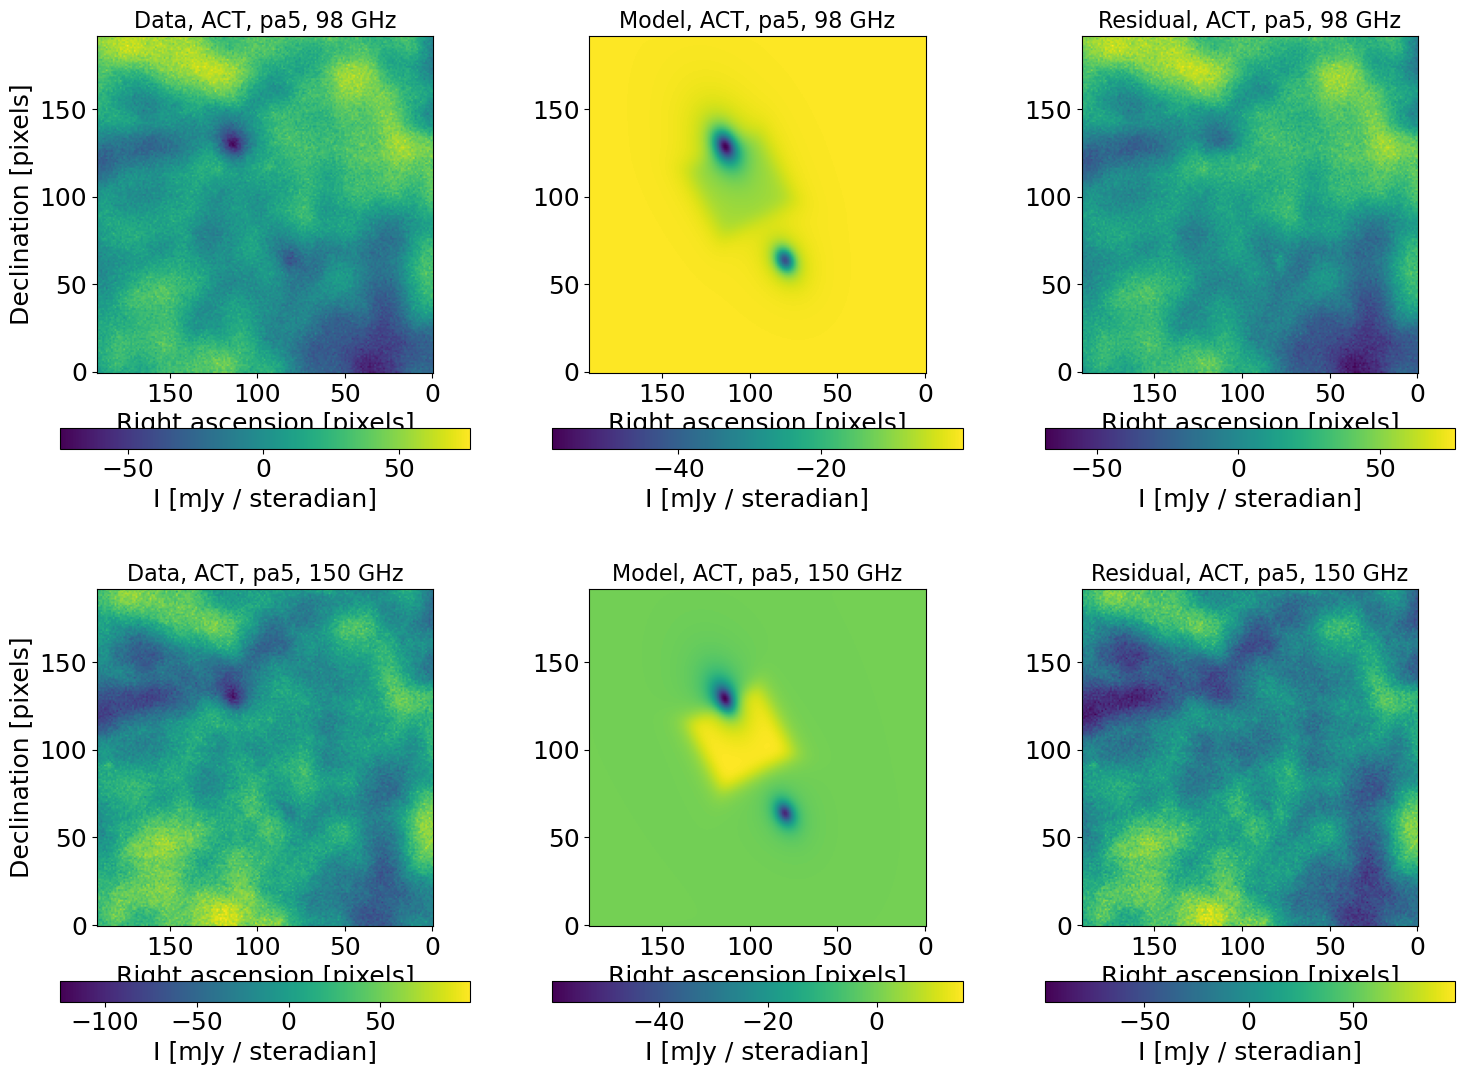

In [28]:
target = "bridge"

model_tot = plotter_sim(filename="/home/gill/research/ACT/bridge/a399_a401/run_test.h5", 
                        target=f"{target}",
                        plot_maps=1,
                        burnin=1,
                        thin=1,
                        plot_contours=0,
                        p_range=None,
                        plot_samples=0,
                        cf_name="../configs/config_mcmc_ajay.yaml",
                        plot_converge=0)